# Exploring molecular interactions using electronic structure methods.

For todays activity we will use the package of programs psi4, so we will need to install it first. 
The psi4 python module can be installed using the anaconda python platform. To do this download anaconda in:

https://www.anaconda.com/download/#linux

You can download either the 2.7 or 3.6 verison depneding on you preference. 

Once downloaded and installed it is recomended to create a psi4 environment form which
the psi4 module can be loaded. Run the comand:

**conda create -n p4env python=2.7 psi4 psi4-rt -c psi4/label/dev -c psi4**

This will install all the psi4 binaries and a python module which can be imported from the notebook.
To finish the installation you need to provide a scratch directory in your .bashrc, for example:

**export PSI_SCRATCH=/home/user_name/scratch/psi4**

Finally source your .bashrc and activate the environment

**source activate p4env**

Now you may open jupyter-notebook and install psi4.



In [7]:
import psi4 
import numpy as np

# 1. Compute the energy of a diatomic molecules.


As a first example we will compute the scf energy of the diatómic molecule hydrogen flouride (HF):


In [8]:
# ==> Opciones Básicas Psi4 <==
# Memoria
psi4.set_memory(int(5e8))
numpy_memory = 500

# Output
psi4.core.set_output_file('output.dat', False)

# Geometría
hf_mol = psi4.geometry("""
0 1
H
F 1 0.917
""")

#psi4.optimize('scf/cc-pvtz')
#di_mat = hf_mol.distance_matrix()
#print np.asarray(di_mat)
energy_hf_mol , wfn_hf_mol = psi4.energy('mp2/cc-pvtz', return_wfn=True)
print energy_hf_mol

-100.34290633


This corresponds to the Born-Oppenheimer scf energy of HF. Now it's your turn. Compute the single point energy 
of F$_2$ and N$_2$ using the cc-pVDZ and cc-pVTZ. 

# 2. Compute the dipole and quadrupole moment of diatomic molecules

Since we are intrested in studying long range  molecular interactions using classical elctrodynamics, it is necessary 
to compute the dipole and quadrupole moments. Quantum mechanically the dipole can be computed using the one electron dipole operator:

\begin{equation}
\hat{\mu} = \sum_i q_i r_i 
\end{equation}

where $q_i$ is the charge of the particle and $r_i$ is the position vector of the particle.  The dipole moment can be computed using the wavefunction through the expectation value of the operator $\mu$.

\begin{equation}
\mu = <\psi|\hat{\mu}|\psi> 
\end{equation}

In psi4 we can obtain the dipole moment from the wafefunction object that was defined above

In [3]:
psi4.oeprop(wfn, 'DIPOLE', 'QUADRUPOLE', title='HF SCF')

mux = psi4.core.get_variable('HF SCF DIPOLE X') # in debye
muy = psi4.core.get_variable('HF SCF DIPOLE Y')
muz = psi4.core.get_variable('HF SCF DIPOLE Z')
quad_zz = psi4.core.get_variable('HF SCF QUADRUPOLE ZZ')

In [4]:
print muz
print quad_zz
mu = (np.sqrt(mux**2 + muy**2 + muz**2))
print mu

-1.94992481269
-3.17622583369
1.94992481269


# 3.  Compute a potential energy surface of HF dimer.

In order to study the physical interactions between two molecules it is convinient to draw 
a potential energy surface along the interaction coordinate. In this section we will 
obtain a potential energy profile for the most favorable dipole-dipole interaction, which is the 
horizontal orientation with oposing dipole vectors, HF---FH. First we need to define a list containing 
the distances between both dimers for which the energy will be obtained.

In [75]:
hf_dimer = psi4.geometry("""
        0 1
        H
        F 1 0.917
        H 2 R 1 180.0
        F 3 0.917 2 180.0 1 0.0
        """)

Next, we write a loop and in each step of the loop we compute the energy at the mp4 level of theory. 

In [89]:
energy = []
dist   = []

Rval = np.arange(1.5,10.0,0.1)

for d in Rval:
    hf_dimer.R = d
    psi4.set_options({'freeze_core': 'True'})
    en = psi4.energy('scf/cc-pvtz')
    print en
    print d
    energy.append(en)
    dist.append(d)


-200.661256547
1.5
-200.663975673
1.6
-200.665389991
1.7
-200.666002762
1.8
-200.666138995
1.9
-200.665998991
2.0
-200.665701798
2.1
-200.665320196
2.2
-200.664901232
2.3
-200.664475292
2.4
-200.664060667
2.5
-200.663667338
2.6
-200.663300238
2.7
-200.662961502
2.8
-200.662651718
2.9
-200.662370559
3.0
-200.662117067
3.1
-200.661889797
3.2
-200.661686891
3.3
-200.661506164
3.4
-200.661345239
3.5
-200.661201724
3.6
-200.661073358
3.7
-200.660958124
3.8
-200.660854292
3.9
-200.660760415
4.0
-200.660675286
4.1
-200.660597893
4.2
-200.660527368
4.3
-200.660462951
4.4
-200.660403978
4.5
-200.660349853
4.6
-200.660300051
4.7
-200.660254106
4.8
-200.660211611
4.9
-200.660172206
5.0
-200.660135581
5.1
-200.660101465
5.2
-200.660069623
5.3
-200.66003985
5.4
-200.660011966
5.5
-200.659985812
5.6
-200.659961249
5.7
-200.659938152
5.8
-200.659916409
5.9
-200.659895918
6.0
-200.659876591
6.1
-200.659858343
6.2
-200.659841099
6.3
-200.65982479
6.4
-200.659809354
6.5
-200.659794731
6.6
-200.65978087


TypeError: list indices must be integers, not float

Now we are ready to plot the potential energy profile. We will use the matplotlib python library for this 
purpose. The function ref_cero_kcal transforms the energy which is in hartee to kcal/mol and takes the 
energy of the dimer with the farthest separation as the reference energy.

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

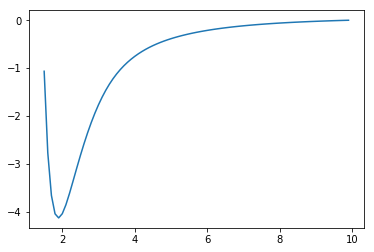

In [95]:
def ref_cero_kcal(en_list):
    energy_kcal = []
    for x in range(len(en_list)):
        energy_kcal.append((en_list[x] - en_list[-1])*627.51)
    return energy_kcal


energy_kcal = ref_cero_kcal(energy)    
plt.plot(dist,energy_kcal)


**Exercise:** Using the data from the plot, make an estimate of the interaction energy in kcal/mol. Corroborate your results computing the interaction energy using the super-molecule approach. ( Hint: 1 hartree = 627.51 kcal/mol). What percentage of the total enregy is the intermolecular interaction energy? 

# 4. The effect of electron correlation

Since we know that the dispersion energy arises only when the motion of the electrons on the different molecular fragments are correlated, it is possible to evalute the importance of disperison efects by using
methods that include diferent levels of electron correlation. 

**Exercice**: Construct a potential energy curve at the SCF, MP2 and MP4 level of theory and 
asses the importance of including electron correlation along the intermolecular coordinate.

# 5. Energy decomposition with SAPT

So far we have only computed the interaction energy as a whole, however we know that we can
decompose the interaction energy into contribiutions stemming from different physical fenomena, 
in particular, electrostatic, induction, dispersion and exchange interactions. First we will run a 
sapt0 calculation to obtain the total interaction energy and compare it to the results we obtained 
above.

In [9]:
hf_dimer_sapt = psi4.geometry('''
     0 1
     H  0.0 0.0 0.0
     F  0.0 0.0 0.917
     --
    0 1
     H  0.0 0.0 2.951
     F  0.0 0.0 3.868
     symmetry c1
''')

psi4.set_options({'basis': 'jun-cc-pVDZ',
                  'e_convergence': 1e-8,
                  'd_convergence': 1e-8})

psi4.energy('sapt0')

-0.006356211476885718

Check the output file for energy decomposition analysis. Which contribuition is dominant, and what do you think
is the physical reason for it? 

**Exercise:** Repeat the above analysis with the Argon dimer $Ar_2$. What can you say about the importance 
of the correlation energy in this case? Which is the dominant contribiution in the case of the Ar dimer?